# Import packages

In [5]:
!pip install transformers
!pip install torch
!pip install torchvision
!pip install timm
!pip install pycocotools
!unzip train_images.zip -d train_images
!rm -rf train_images.zip
!unzip test_images.zip -d test_images
!rm -rf test_images.zip

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 106 kB 7.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements 

In [28]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
import json
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm

In [16]:
torch.cuda.is_available()

False

# Convert Data into COCO formatted Dataset

In [10]:
def convert_bbox_definition(left: int, top: int, right: int, bottom: int) -> list:
    '''
    Converts bounding box definition from:
    
    `class_name top_left_x top_left_y bottom_right_x bottom_right_y`

    to the proper COCO formatting defined as:

    `top_left_x top_left_y width height`

    '''
    top_left_x = left
    top_left_y = top
    width = right - left
    height = bottom - top

    bbox = [top_left_x, top_left_y, width, height]
    return bbox

In [11]:
def convert2coco(path: str) -> dict:
    '''
    Creates the correct label formatting for the model to train on defined as a dictionary with keys `image_id` and `annotations` where `annotations` is a list of dictionaries with each dictionary being a COCO object annotation
    '''

    d = {
        "info": {
            "description": "Tactile Paving Dataset from Crowd4Access",
            "year": 2022
        },

        "licenses": [
            {
                "id": 0,
                "name": "Attribution-ShareAlike 4.0 International",
                "url": "https://creativecommons.org/licenses/by-sa/4.0/legalcode"
            }
        ],

        "images": [],

        "annotations": [],

        "categories": [
            {
                "id": 0,
                "name": "tactile_paving",
                "supercategory": "tactile_paving"
            }
        ]
    }

    i = 0 # counter for creating new image ids
    j = 0 # counter for annotation ids

    for item in os.listdir(path + "/image"): # look at every image in path
        
        filename = item.split(".")[0] # split on file extension and just get id
        
        with open(f"{path}/label/{filename}.txt", "r") as f:
            # ANNOTATIONS
            for line in f.readlines():
                split_line = line.split(" ")
                
                # each bbox is defined as (class left top right bottom) as a new line in the corresponding .txt file

                image_class = split_line[0].strip()
                bbox_left = int(split_line[1].strip())
                bbox_top = int(split_line[2].strip())
                bbox_right = int(split_line[3].strip())
                bbox_bottom = int(split_line[4].strip("\n"))

                new_bbox = convert_bbox_definition(
                    bbox_left,
                    bbox_top,
                    bbox_right,
                    bbox_bottom
                )

                unique_coco_annotation = {
                    "image_id": i,
                    "bbox": new_bbox,
                    "id": j,
                    "category_id": 0,
                    "segmentation": [],
                    "area": 0,
                    "iscrowd": 0
                }

                d["annotations"].append(unique_coco_annotation)
                
                j += 1

        # IMAGES
        image = Image.open(path + "/image/" + item)
        height = image.size[1]
        width = image.size[0]
        id = i
        license = 0
        file_name = item

        unique_coco_image = {
            "id": id,
            "file_name": file_name,
            "width": width,
            "height": height,
            "license": license
        }

        d["images"].append(unique_coco_image)

        i += 1
    return d

In [4]:
data_as_coco = convert2coco("crowd4access-images/crowd4access-images/trainval")
test_data_as_coco = convert2coco(:"crowd4access-images/crowd4access-images/test")

FileNotFoundError: [Errno 2] No such file or directory: 'crowd4access-images/crowd4access-images/trainval/label/custom_train.txt'

In [14]:
# with open("crowd4access-images/crowd4access-images/trainval/image/custom_train.json", "w") as f:
#     json.dump(data_as_coco, f)

# with open("crowd4access-images/crowd4access-images/test/image/custom_test.json","w") as f:
#     json.dump(test_data_as_coco, f)

# Make a Dataset that can be read by torch.Dataloader

In [17]:
path_to_train_data = "crowd4access-images/crowd4access-images/trainval/image"
path_to_test_data = "crowd4access-images/crowd4access-images/test/image"

In [18]:
class CocoDetection(torchvision.datasets.CocoDetection):
    """
    Huge thank you to Niels Rogge, all this was written by him except for me changing filepaths
    """
    def __init__(self, img_folder: str, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [19]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", num_labels=1, ignore_mismatched_sizes=True)

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=path_to_train_data, feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=path_to_test_data, feature_extractor=feature_extractor, train=False)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Image 935


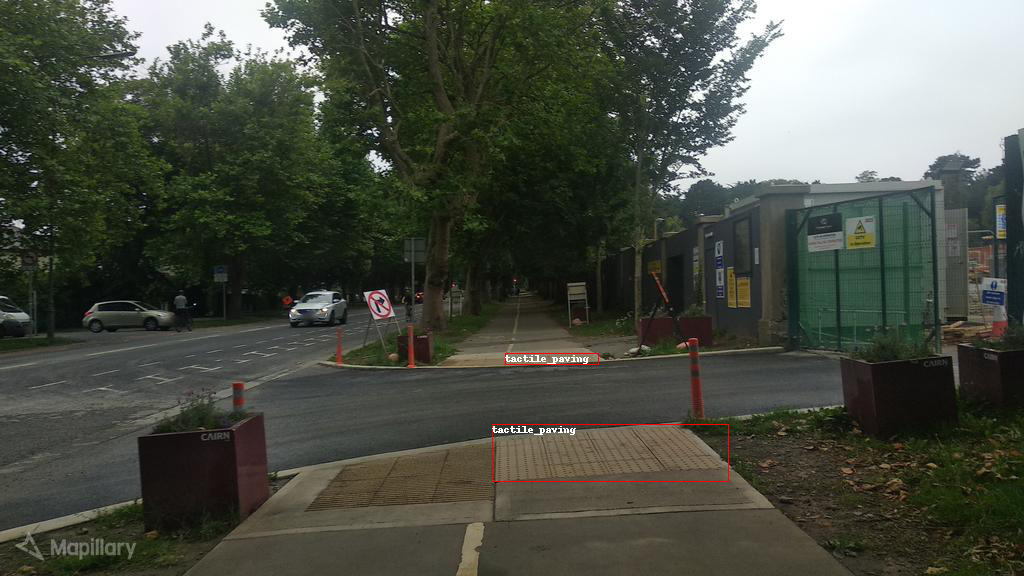

In [27]:
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print(f'Image {image_id}')
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(path_to_train_data, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [30]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]

    encoding = feature_extractor.pad_and_create_pixel_mask(
        pixel_values,
        return_tensors="pt"
    )
    
    labels = [item[1] for item in batch]

    # labels = transformers.BatchFeature

    batch = {}

    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    
    return batch

In [31]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=2,
    shuffle=True,
    num_workers=4
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_fn,
    batch_size=2
)

# Training!

In [52]:
optimizer = AdamW(model.parameters(), lr=1e-4)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
progress_bar = tqdm(range(num_training_steps))

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
  0%|          | 0/2703 [00:00<?, ?it/s]

In [73]:
model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = []

        for label in batch["labels"]:
            labels.append({k: v.to(device) for k, v in label.items()})

        outputs = model(
            pixel_values=batch["pixel_values"],
            pixel_mask=batch["pixel_mask"],
            labels=labels
        )
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

/home/dadofapollo/miniconda3/envs/tactile-paving/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)
  1%|          | 14/2703 [45:30<13:04:08, 17.50s/it] 

KeyboardInterrupt: 

In [74]:
path_to_weights = "trained_weights"

model.save_pretrained(path_to_weights)

In [75]:
loaded_model = DetrForObjectDetection.from_pretrained("trained_weights")

In [112]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [103]:
model.to(device)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrTimmConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (act2): ReLU(inplace=True)
                (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn3)

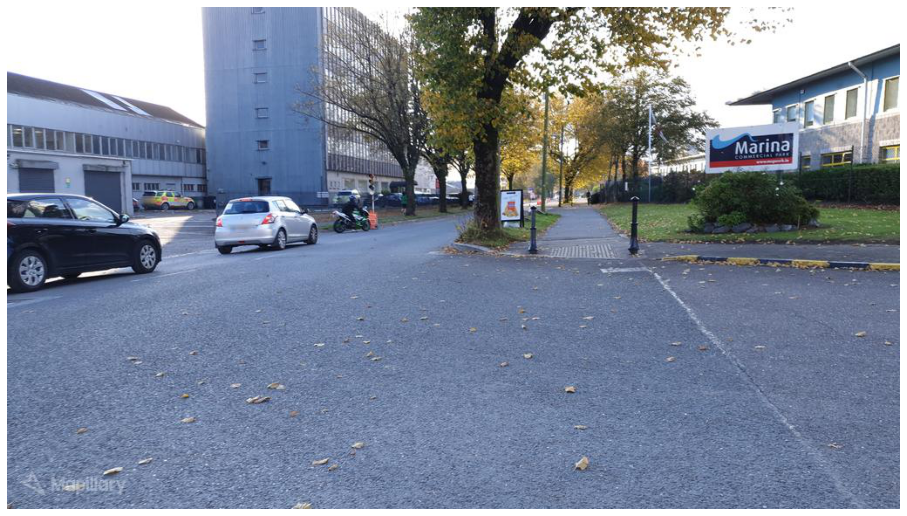

In [113]:
# pixel_values, target = test_dataset[1]
# pixel_values = pixel_values.unsqueeze(0).to(device)
# outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('test_images/image', image['file_name']))

visualize_predictions(image, outputs)

In [114]:
outputs

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-2.2854,  3.1957],
         [-1.9445,  1.9765],
         [-1.7425,  2.2314],
         [-2.1336,  2.4302],
         [-1.9857,  1.9904],
         [-0.9365,  1.0832],
         [-1.3867,  1.4220],
         [-1.8618,  1.8859],
         [-2.6378,  2.3966],
         [-2.7428,  2.7951],
         [-0.5478,  1.0588],
         [-1.6557,  2.5406],
         [-1.0982,  1.7129],
         [-0.4849,  1.1624],
         [-0.8213,  0.8625],
         [-2.1620,  2.6880],
         [-2.7921,  3.1088],
         [-1.8179,  2.6048],
         [-0.9243,  1.6718],
         [-1.5313,  1.4297],
         [-1.8648,  1.8177],
         [-0.3610,  0.8484],
         [-2.3679,  2.6423],
         [-1.7638,  1.7675],
         [-1.2059,  1.6258],
         [-0.7230,  0.6455],
         [-1.8664,  2.5091],
         [-1.5648,  1.2251],
         [-2.1584,  2.2590],
         [-1.7230,  2.8219],
         [-1.2308,  2.4243],
         [-0.8767,  0.8320],
         [-2